In [1]:
from PIL import Image
import cv2 as cv
import requests
from io import BytesIO
import os
import random
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import pickle
import string
import re
import spacy
import nltk
from nltk.stem.snowball import SnowballStemmer

import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

/home/garima/anaconda3/lib/python3.7/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
### LOAD DRESS ###
data = pd.read_csv('fashion_dataset.csv').fillna(' ')
print(data.shape)
data.head(3)

(8792, 3)


,Unnamed: 0,Links,Descriptions
0,0,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,"['short, sexy, summer, sexy, party, yellow dre..."
1,1,https://i6.ztat.net/large/V1/02/1C/0T/QK/11/V1...,['blue knee-length ladies dress with white dot...
2,2,https://i6.ztat.net/large/TF/72/1C/01/5K/11/TF...,['This product is a dress. It is striped gray ...


In [3]:
# The vgg model will output the features of images and these features will be further used for clustering

In [4]:
### LOAD VGG ###
vgg_model = vgg16.VGG16(weights='imagenet')
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
feat_extractor.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [7]:
### PREPARE IMAGES FOR VGG ###
## A) READ IMAGES AND EXPAND DIM
importedImages = []

for url in tqdm(data['Links'][:10]):
    
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((224, 224))
    numpy_img = img_to_array(img)
    img_batch = np.expand_dims(numpy_img, axis=0)
    importedImages.append(img_batch.astype('float16'))
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


In [8]:
### EXTRACT FEATURES ###
## B) MAKE PREDICTION
imgs_features = feat_extractor.predict(processed_imgs)
imgs_features.shape

(10, 4096)

In [11]:
with open("./img2feat.pkl", 'wb') as f:
    pickle.dump(imgs_features,f)

In [12]:
### A + B (DONE AND STORED IN A PICKLE) ###
with open("./img2feat.pkl", 'rb') as pickle_file:
    imgs_features = pickle.load(pickle_file)

print(imgs_features.shape)

(10, 4096)


In [13]:
### SPLIT TRAIN TEST ###
train = imgs_features[:7]
print(train.shape)

test = imgs_features[7:]
print(test.shape)

(7, 4096)
(3, 4096)


# VISUALIZE DRESS

In [15]:
### REDUCE FEATURE DIMENSIONS ###
pca = PCA(n_components=5, random_state=33)
pca_score = pca.fit_transform(imgs_features)

tsne = TSNE(n_components=2, random_state=33, n_iter=300, perplexity=5)
T = tsne.fit_transform(pca_score)

100%|██████████| 200/200 [02:47<00:00,  1.19it/s]


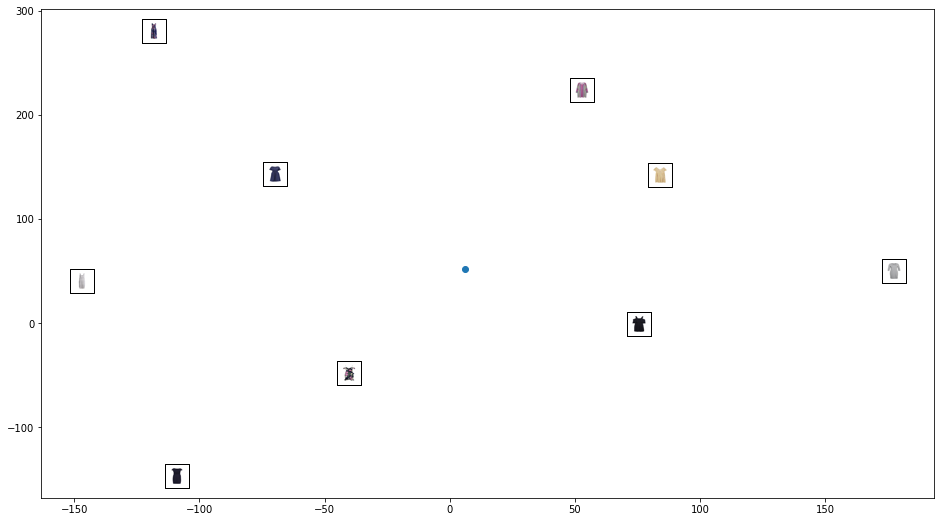

In [18]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(T.T[0], T.T[1]) 
plt.grid(False)

shown_images = np.array([[1., 1.]])
for i in tqdm(np.random.randint(1,T.shape[0],200)):
    
    response = requests.get(data['Links'][i])
    img = Image.open(BytesIO(response.content))
    img = img.resize((16, 16))
    
    shown_images = np.r_[shown_images, [T[i]]]
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img, cmap=plt.cm.gray_r), T[i])
    ax.add_artist(imagebox)

plt.show()

# IMAGES SIMILARITY

In [24]:
### PASS THE TEST ID TO GET THE MOST SIMILAR PRODUCTS ###
def most_similar_products(test_id, n_sim = 3):
    
    #open-plot image
    plt.subplot(1, n_sim+1, 1)
    org_response = requests.get(data['Links'][train.shape[0]+test_id])
    original = Image.open(BytesIO(org_response.content))
    original = original.resize((224, 224))
    plt.imshow(original)
    plt.title('ORIGINAL')
    
    #compute similarity matrix
    cosSimilarities_serie = cosine_similarity(train, test[test_id].reshape(1,-1)).ravel()
    cos_similarities = pd.DataFrame({'sim':cosSimilarities_serie,'id':data[:train.shape[0]].index},
                                    index=data['Links'][:train.shape[0]]).sort_values('sim',ascending=False)[0:n_sim+1]

    #plot n most similar
    for i in range(0,n_sim):
        
        plt.subplot(1, n_sim+1, i+1+1)
        org_response = requests.get(cos_similarities.index[i])
        original = Image.open(BytesIO(org_response.content))
        original = original.resize((224, 224))
        plt.imshow(original)
        plt.title('Similar'+str(i+1)+': '+str(cos_similarities.sim[i].round(3)))

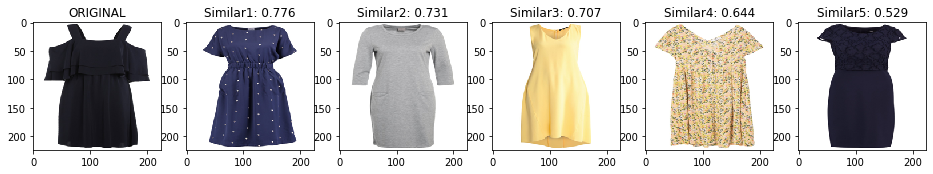

In [25]:
plt.figure(figsize=(16,8))
most_similar_products(1,5)
plt.show()

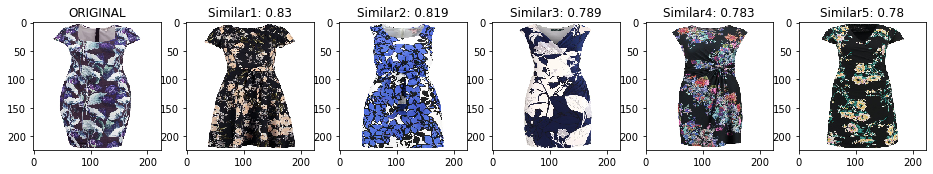

In [11]:
plt.figure(figsize=(16,8))
most_similar_products(28,5)
plt.show()

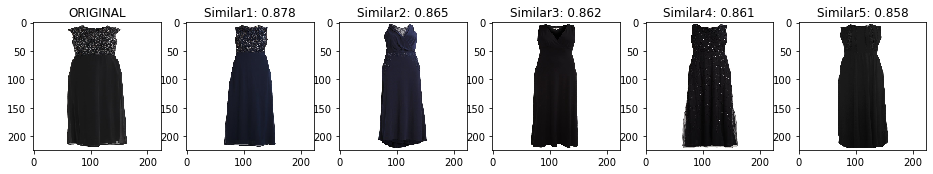

In [12]:
plt.figure(figsize=(16,8))
most_similar_products(9,5)
plt.show()

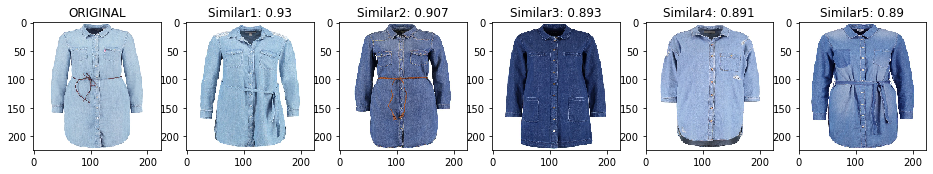

In [13]:
plt.figure(figsize=(16,8))
most_similar_products(10,5)
plt.show()

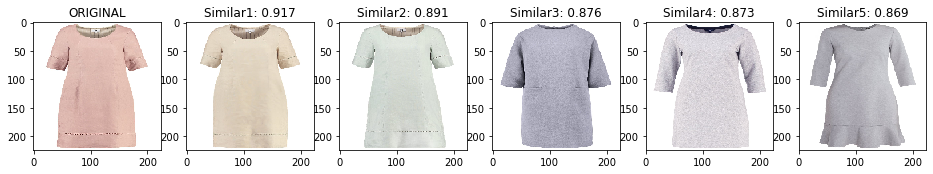

In [14]:
plt.figure(figsize=(16,8))
most_similar_products(347,5)
plt.show()